# Unit Commitment problem using Quantum Annealers

- Explain what the UC problem is
- Why quantum annealers

In [1]:
import sys
sys.path.append('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing')
from util.utils import get_index
from util.plots import plot_schedule
from uc_annealing import UC_Annealing

# Import data

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

demand = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Demand.csv')
fuel_data = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Fuels_data.csv')
generator = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_data.csv')
variability = pd.read_csv('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing/data/Generators_variability.csv')

We only want to keep the generators for which commitment is necessary

In [5]:
thermal_generators = generator[generator['Up_time']>0]
thermal_generators = thermal_generators.drop_duplicates(subset=['Resource'], keep='first')
thermal_generators

,R_ID,Resource,region,Existing_Cap_MW,num_units,Cap_size,Var_OM_cost_per_MWh,Var_OM_cost_per_MWh_in,Fuel,Heat_rate_MMBTU_per_MWh,heat_rate_mmbtu_mwh_iqr,heat_rate_mmbtu_mwh_std,Min_power,Ramp_Up_percentage,Ramp_Dn_percentage,Start_cost_per_MW,Start_fuel_MMBTU_per_MW,Up_time,Down_time,Self_disch,Eff_up,Eff_down,Ratio_power_to_energy,Min_Duration,Max_Duration,cluster,zone,voltage_level,CapRes,THERM,DISP,NDISP,STOR,DR,HEAT,NACC,TRADER,HYDRO,RPS,CES,Commit,Min_Share,Max_Share,Existing_Cap_MWh,unmodified_existing_cap_mw,New_Build,Min_Cap_MW,Max_Cap_MW,Min_Share_percent,Max_Share_percent,capex,Inv_cost_per_MWyr,Fixed_OM_cost_per_MWyr,capex_mwh,Inv_cost_per_MWhyr,Fixed_OM_cost_per_MWhyr,NACC_Eff,NACC_Peak_to_Base,Reg_Up,Reg_Dn,Rsv_Up,Rsv_Dn,Reg_Cost,Rsv_Cost,spur_miles,spur_capex,offshore_spur_miles,offshore_spur_capex,tx_miles,tx_capex,interconnect_annuity,Max_DSM_delay
2,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1,607.1,3.4,0,pacific_naturalgas,7.52,0.0,0.0,0.362,0.40,0.40,87,2.0,6,6,0,1.0,1.0,1.0,0,0,1,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,607.1,1,0,0.0,0,0,0.000,0.0,9270,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
8,9,natural_gas_fired_combustion_turbine,WEC_SDGE,91.6,2,45.8,10.8,0,pacific_naturalgas,10.69,0.0,0.0,0.800,3.78,3.78,113,3.5,1,1,0,1.0,1.0,1.0,0,0,1,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,91.6,1,0,0.0,0,0,0.000,0.0,11182,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
25,26,naturalgas_ccccsavgcf,WEC_SDGE,0.0,0,500.0,7.2,0,pacific_naturalgas_ccs90,7.52,0.0,0.0,0.600,0.64,0.64,95,3.5,6,6,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1,0,-1.0,0,0,2215517.785,229065.0,33620,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
26,27,naturalgas_ccavgcf,WEC_SDGE,0.0,0,500.0,2.0,0,pacific_naturalgas,6.28,0.0,0.0,0.200,0.64,0.64,95,3.5,6,6,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1,0,-1.0,0,0,804772.856,114863.0,10032,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
27,28,naturalgas_ctavgcf,WEC_SDGE,0.0,0,100.0,10.8,0,pacific_naturalgas,9.35,0.0,0.0,0.300,3.78,3.78,123,3.5,1,1,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1,0,-1.0,0,0,699302.872,90151.0,6848,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0
29,30,naturalgas_ccs100,WEC_SDGE,0.0,0,500.0,7.7,0,pacific_naturalgas_ccs100,7.88,0.0,0.0,0.600,0.64,0.64,95,3.5,6,6,0,1.0,1.0,1.0,0,0,0,1,trans,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0.0,1,0,-1.0,0,0,2331517.785,241058.0,43290,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0


## Problem formulation

We start with a simple formulation of the problem which aims at minimising the cost of operating power plants, while meeting energy demand and subject to energy bounds.


$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} \\
\end{align}
$$
$$
\begin{align}
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} \times COMMIT_{g,t} & \forall \quad g \in G_{thermal} , t \in T \\
\end{align}
$$


The **decision variables** in the above problem:

- $GEN_{g}$, generation (in MW) produced by each generator, $g$
- $COMMIT_{g,t}$, commitment status (binary) of generator $g$ at time $t$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for generator $g$ (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)
- $VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g$, the variable cost of generator $g$ 

In addition, we introduce a few different sets:

- $G$, the set of all generators
- $G_{thermal} \subset G$, the subset of thermal generators for which commitment is necessary
- $T$, the set of all time periods over which we are optimizing commitment and dispatch decisions

Finally, the **three-variable commitment equations** capture the basic logic of commitment:

- Units incur costs when they startup (not when they shutdown)
- Units must stay on (and off) for a minimum period of time&mdash;in lieu of explicitly enforcing a startup trajectory
- Some summations (simplified here) will need to be modified near the beginning of the time period

## Quantum Annealing

In [ ]:
import dwave
import dimod
import os
from dwave.system import LeapHybridCQMSampler
from dimod import QuadraticModel, ConstrainedQuadraticModel, Binary, Integer
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

In [6]:
# define a constrained quadratic model instance
cqm = ConstrainedQuadraticModel()

In [7]:
n_hours = 24
n_generators = thermal_generators.shape[0]
day_demand = demand['Demand'][:n_hours].values

#define the commitment variable
x = {(n, t): Binary('x_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

#define the generation variable 
y = {(n, t): Integer('y_{}_{}'.format(n, t)) for n, rows in thermal_generators.iterrows() for t in range(n_hours)}

Objective function:

In [8]:
objective = QuadraticModel()
for generator, row in thermal_generators.iterrows():
    for hour in range(n_hours):
        heat_rate = thermal_generators['Heat_rate_MMBTU_per_MWh'][generator]
        fuel = thermal_generators['Fuel'][generator]
        fuel_cost = fuel_data[fuel_data['Fuel'] == fuel]['Cost_per_MMBtu'].values[0]
        VarOM = thermal_generators['Var_OM_cost_per_MWh'][generator]

        objective.update((heat_rate * fuel_cost + VarOM) * y[generator, hour])
        
cqm.set_objective(objective)

Energy demand constraint:

In [9]:
#define the energy demand contraint
for hour in range(n_hours):
    sum_energies = QuadraticModel()
    for generator, row in thermal_generators.iterrows():
        sum_energies += y[generator, hour]
    cqm.add_constraint(sum_energies >= day_demand[hour], label = f'energy demand hour {hour}')

Energy bounds:

In [10]:
#define the energy bounds
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']
        
        cqm.add_constraint(x[generator, hour] * existing_cap * min_power - y[generator, hour] <= 0,
                           label = f'energy lower bound generator {generator} at {hour}')
        
        cqm.add_constraint(x[generator, hour] * existing_cap - y[generator, hour] >= 0,
                           label = f'energy upper bound generator {generator} at {hour}')

Sample the problem using the LeapHybridCQMSampler

In [12]:
#sample 
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)
sample = raw_sampleset.first

In [13]:
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)
print(best_samples)

best_sample = best_samples.first.sample
# Separate x and y variables into two dictionaries
x_results = {}
y_results = {}

for key, value in best_sample.items():
    if key.startswith('x'):
        x_results[key] = value
    elif key.startswith('y'):
        y_results[key] = value

 
==============================BEST SAMPLE SET==============================
  x_25_0 x_25_1 x_25_10 x_25_11 x_25_12 ... y_8_9      energy num_oc. ...
0    0.0    1.0     1.0     1.0     1.0 ...   1.0 425265.4368       1 ...
1    0.0    1.0     1.0     0.0     1.0 ...  38.0 450658.9768       1 ...
2    0.0    1.0     1.0     0.0     0.0 ...  55.0 493570.6849       1 ...
3    1.0    1.0     0.0     0.0     0.0 ...  66.0   502819.05       1 ...
4    1.0    0.0     0.0     1.0     0.0 ...   3.0 507830.5009       1 ...
5    0.0    1.0     1.0     0.0     1.0 ...  10.0 507925.0423       1 ...
6    1.0    0.0     0.0     0.0     0.0 ...  75.0  521655.739       1 ...
7    0.0    1.0     0.0     0.0     1.0 ...  74.0 525614.4257       1 ...
8    0.0    1.0     0.0     1.0     0.0 ...  91.0 527265.3773       1 ...
9    1.0    1.0     1.0     1.0     0.0 ...  78.0 539447.6238       1 ...
['INTEGER', 10 rows, 10 samples, 288 variables]


In [14]:
# Prepare the data
generators = []
times = []
energies = []
resource = []
status = []

for key, value in y_results.items():
    key_parts = key.split('_')
    _, generator, time = key_parts
    generators.append(int(generator))
    times.append(int(time))
    energies.append(value)
    resource.append(thermal_generators['Resource'][int(generator)])

for key, value in x_results.items():
    status.append(value)

# Create a DataFrame
data_df = pd.DataFrame({
    'Generator': generators,
    'Resource' : resource,
    'Time': times,
    'Generated Energy': energies,
    'Status': status
})

Plot results

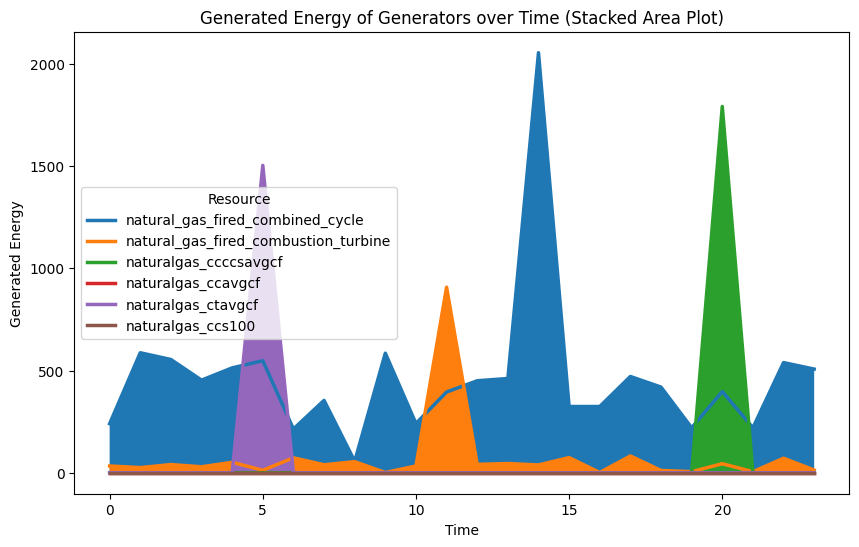

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Sort the DataFrame by the Generator and Time columns
data_df.sort_values(['Generator', 'Time'], inplace=True)

# Create the stacked area plot
plt.figure(figsize=(10, 6))
for generator, df_group in data_df.groupby('Generator'):
    sns.lineplot(x='Time', y='Generated Energy', data=df_group, linewidth=2.5, label=df_group.iloc[0]['Resource'])
    plt.fill_between(df_group['Time'], df_group['Generated Energy'], alpha=1)  # Fill area below the lines
plt.xlabel('Time')
plt.ylabel('Generated Energy')
plt.title('Generated Energy of Generators over Time (Stacked Area Plot)')
plt.legend(title='Resource')
plt.show()

# Classical implementation

In [16]:
from pulp import *

# Create a MILP problem
prob = LpProblem("Unit_Commitment_Problem", LpMinimize)

In [17]:
n_hours = 24
n_generators = thermal_generators.shape[0]
day_demand = demand['Demand'][:n_hours].values

# Decision variables
x = LpVariable.dicts("x", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Binary")
y = LpVariable.dicts("y", [(generator, t) for generator, rows in thermal_generators.iterrows() for t in range(n_hours)], cat="Integer")

In [18]:
prob += lpSum([(row['Heat_rate_MMBTU_per_MWh'] * 
                fuel_data[fuel_data['Fuel'] == thermal_generators['Fuel'][generator]]['Cost_per_MMBtu'].values[0]
                + row['Var_OM_cost_per_MWh']) * y[generator, t]
                for generator, row in thermal_generators.iterrows() for t in range(n_hours)])

In [21]:
#define the energy demand contraint
for hour in range(n_hours):
    prob += lpSum([y[generator, hour] for generator, row in thermal_generators.iterrows()]) >= day_demand[hour]

In [22]:
#define the energy demand contraint
for hour in range(n_hours):
    for generator, row in thermal_generators.iterrows():
        existing_cap = row['Existing_Cap_MW']
        min_power = row['Min_power']

        prob += lpSum([x[generator, hour] * existing_cap * min_power - y[generator, hour]]) <= 0
        prob += lpSum([x[generator, hour] * existing_cap - y[generator, hour]]) >= 0

In [23]:
# Solve the problem
prob.solve()

# Check the solution status
if LpStatus[prob.status] == 'Optimal':
    # Retrieve the optimal solution
    solution = {(n, t): value(x[n, t]) for n in range(n_generators) for t in range(n_hours)}
    total_cost = value(prob.objective)

else:
    print("No feasible solution found.")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juanfrancisco/Desktop/uc/uc-problem-annealing/env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/77f22dc8ee2745e29e038ec3e7630e94-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/77f22dc8ee2745e29e038ec3e7630e94-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 317 COLUMNS
At line 1374 RHS
At line 1687 BOUNDS
At line 1880 ENDATA
Problem MODEL has 312 rows, 192 columns and 528 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.02

No feasible solution found.


In [266]:
classical_solution = [(n, t) for (n, t), value in solution.items() if value == 1.0]

NameError: name 'solution' is not defined